In [2]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 2.9 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/13.3 MB 36.7 MB/s eta 0:00:01
   ------------------ --------------------- 6.1/13.3 MB 48.5 MB/s eta 0:00:01
   --------------------------- ------------ 9.2/13.3 MB 53.3 MB/s eta 0:00:01
   --------------------------------- ------ 11.1/13.3 MB 65.2 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 65.6 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 59.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/94.5 kB ? eta -:--:--
   ---------------------------------------- 94.5/94.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 69.4 MB/s eta 0:00:00


In [3]:
!pip install blp

In [4]:
!pip install xbbg

In [26]:
import blpapi
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns

In [6]:
# Function to fetch data from Bloomberg
def fetch_bloomberg_data(tickers, start_date, end_date):
    from blpapi import SessionOptions, Session
    from blpapi import Request
    sessionOptions = SessionOptions()
    session = Session(sessionOptions)

    if not session.start():
        print("Failed to start session.")
        return None

    if not session.openService("//blp/refdata"):
        print("Failed to open //blp/refdata")
        return None

    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("HistoricalDataRequest")

    for ticker in tickers:
        request.getElement("securities").appendValue(ticker)

    request.getElement("fields").appendValue("PX_LAST")
    request.set("startDate", start_date)
    request.set("endDate", end_date)
    request.set("periodicitySelection", "DAILY")

    session.sendRequest(request)

    data = {}
    while True:
        ev = session.nextEvent()
        for msg in ev:
            if msg.hasElement("securityData"):
                securityData = msg.getElement("securityData")
                security = securityData.getElementAsString("security")
                fieldDataArray = securityData.getElement("fieldData")
                prices = []
                dates = []
                for fieldData in fieldDataArray.values():
                    date = fieldData.getElementAsDatetime("date").strftime("%Y-%m-%d")
                    price = fieldData.getElementAsFloat("PX_LAST")
                    dates.append(date)
                    prices.append(price)
                data[security] = pd.Series(prices, index=pd.to_datetime(dates))
        if ev.eventType() == blpapi.Event.RESPONSE:
            break

    session.stop()
    return pd.DataFrame(data)


In [7]:
# Define the stocks (Bloomberg tickers)
stocks = ['NVDA US Equity', 'AAPL US Equity', 'TSLA US Equity', 'META US Equity', 'GOOGL US Equity', 'MSFT US Equity']

# Download historical stock price data from Bloomberg
data = fetch_bloomberg_data(stocks, '20200101', '20240601')

# Prepare the data for Prophet
def prepare_prophet_data(df, stock_name):
    df_prophet = df.reset_index().rename(columns={'index': 'ds', stock_name: 'y'})
    return df_prophet

# Initialize a dictionary to hold Prophet models and predictions
models = {}
predictions = {}
metrics = {}

# Train Prophet models for each stock
for stock in stocks:
    df = data[[stock]].dropna()
    df_prophet = prepare_prophet_data(df, stock)

    model = Prophet()
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)

    models[stock] = model
    predictions[stock] = forecast[['ds', 'yhat']].set_index('ds')

    # Evaluate the model's accuracy on the training data
    y_true = df_prophet['y']
    y_pred = forecast['yhat'][:len(y_true)]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = (abs(y_true - y_pred) / y_true).mean() * 100

    metrics[stock] = {'MAE': mae, 'MSE': mse, 'MAPE': mape}

13:52:04 - cmdstanpy - INFO - Chain [1] start processing
13:52:04 - cmdstanpy - INFO - Chain [1] done processing
13:52:05 - cmdstanpy - INFO - Chain [1] start processing
13:52:05 - cmdstanpy - INFO - Chain [1] done processing
13:52:05 - cmdstanpy - INFO - Chain [1] start processing
13:52:05 - cmdstanpy - INFO - Chain [1] done processing
13:52:05 - cmdstanpy - INFO - Chain [1] start processing
13:52:06 - cmdstanpy - INFO - Chain [1] done processing
13:52:06 - cmdstanpy - INFO - Chain [1] start processing
13:52:06 - cmdstanpy - INFO - Chain [1] done processing
13:52:06 - cmdstanpy - INFO - Chain [1] start processing
13:52:06 - cmdstanpy - INFO - Chain [1] done processing


In [10]:

# Calculate the Pearson correlation coefficient between HUBS's predicted stock price and each customer's predicted stock price
hubs_pred = predictions['META US Equity']['yhat']
correlations = {}

for stock in stocks[1:]:
    cust_pred = predictions[stock]['yhat']
    corr, _ = pearsonr(hubs_pred, cust_pred)
    correlations[stock] = corr

# Output the results
print("Model Accuracy Metrics for META:")
print(metrics['META US Equity'])
print("\nPearson Correlation Coefficients:")
print(correlations)

Model Accuracy Metrics for HUBS:
{'MAE': 16.34781875411644, 'MSE': 448.59616582932995, 'MAPE': 6.301792266247159}

Pearson Correlation Coefficients:
{'AAPL US Equity': 0.59689416854867, 'TSLA US Equity': -0.24324985441858307, 'META US Equity': 1.0, 'GOOGL US Equity': 0.9095467670812103, 'MSFT US Equity': 0.9296095436188445}


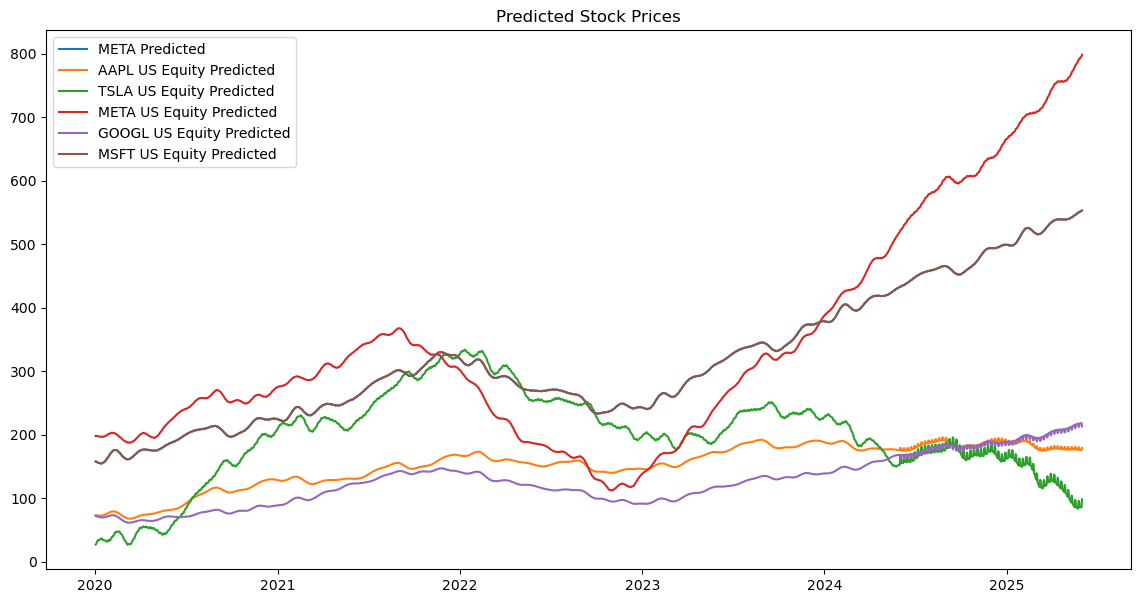

In [12]:

# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(cust_pred, label='META Predicted')
for stock in stocks[1:]:
    plt.plot(predictions[stock]['yhat'], label=f'{stock} Predicted')
plt.legend()
plt.title('Predicted Stock Prices')
plt.show()

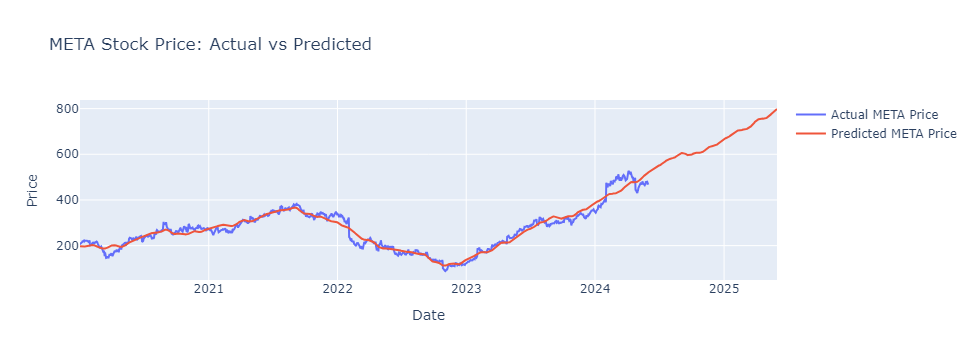

In [14]:
# Use Plotly to plot actual vs predicted prices for NVDA
import plotly.graph_objects as go

# Extract actual and predicted prices for NVDA
actual_nvda = prepare_prophet_data(data[['META US Equity']].dropna(), 'META US Equity')
predicted_nvda = predictions['META US Equity']

# Create the Plotly figure
fig = go.Figure()

# Add the actual price trace
fig.add_trace(go.Scatter(x=actual_nvda['ds'], y=actual_nvda['y'], mode='lines', name='Actual META Price'))

# Add the predicted price trace
fig.add_trace(go.Scatter(x=predicted_nvda.index, y=predicted_nvda['yhat'], mode='lines', name='Predicted META Price'))

# Update layout for better presentation
fig.update_layout(title='META Stock Price: Actual vs Predicted',
                  xaxis_title='Date',
                  yaxis_title='Price')

# Display the plot
fig.show()

In [18]:
def fetch_stock_data(ticker, start_date, end_date):
    session = blpapi.Session()
    if not session.start():
        raise Exception("Failed to start Bloomberg session.")
    if not session.openService("//blp/refdata"):
        raise Exception("Failed to open Bloomberg service.")
    refDataService = session.getService("//blp/refdata")
    request = refDataService.createRequest("HistoricalDataRequest")
    request.getElement("securities").appendValue(ticker)
    request.getElement("fields").appendValue("PX_LAST")
    request.set("startDate", start_date.replace("-", ""))
    request.set("endDate", end_date.replace("-", ""))
    request.set("periodicitySelection", "DAILY")
    session.sendRequest(request)
    data = []
    while True:
        ev = session.nextEvent()
        for msg in ev:
            if msg.hasElement("securityData"):
                fieldDataArray = msg.getElement("securityData").getElement("fieldData")
                for fd in fieldDataArray.values():
                    date = fd.getElementAsDatetime("date").strftime('%Y-%m-%d')
                    price = fd.getElementAsFloat("PX_LAST")
                    data.append((date, price))
        if ev.eventType() == blpapi.Event.RESPONSE:
            break
    session.stop()
    df = pd.DataFrame(data, columns=['ds', 'y'])
    return df

14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error: 40.35633737398587
R^2 Score: -1.3152689853758468


C:\Users\bs23895\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\bs23895\AppData\Local\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\bs23895\AppData\Local\Temp\ipykernel_38908\3452686694.py:28: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



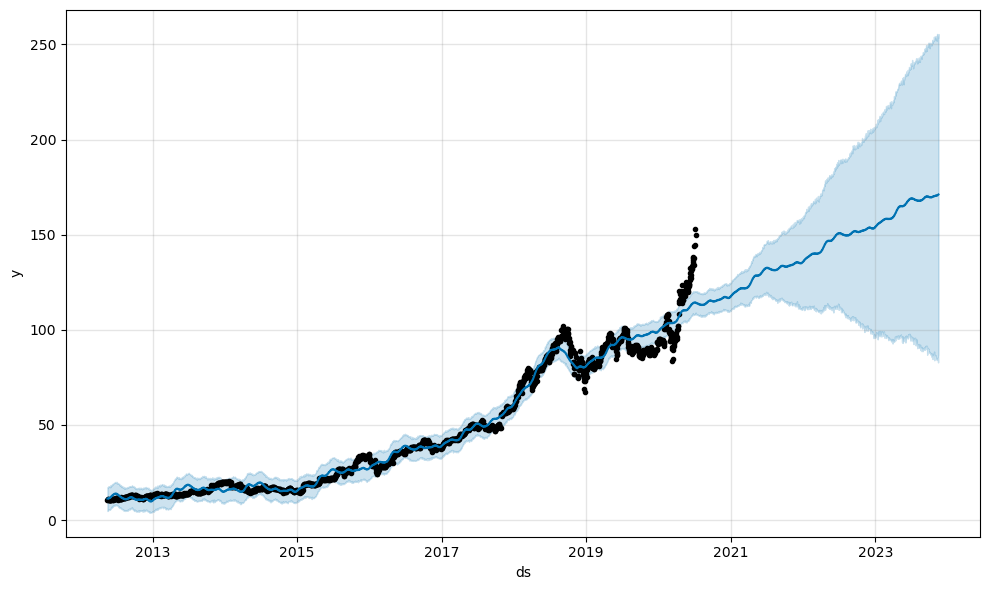

In [22]:
# Specify the ticker, start date, and end date
ticker = 'AMZN US Equity'  # Example: Amazon Inc.
start_date = '2012-05-18'
end_date = '2023-12-31'
 
# Fetch the stock data
df = fetch_stock_data(ticker, start_date, end_date)
 
# Split the data into training and test sets
train_size = int(0.7 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]
 
# Initialize the Prophet model
model = Prophet()
 
# Fit the model on the training data
model.fit(train_df)
 
# Make a dataframe with future dates for prediction
future = model.make_future_dataframe(periods=len(test_df), freq='B')
 
# Predict on the future dates
forecast = model.predict(future)
 
# Plot the forecast
fig = model.plot(forecast)
fig.show()
 
# Evaluate the model
predictions = forecast.tail(len(test_df))['yhat']
rmse = np.sqrt(mean_squared_error(test_df['y'], predictions))
r2 = r2_score(test_df['y'], predictions)
 
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')



The below code is used to understand trends and patterns in the market

In [23]:
# Function to fetch stock data from Bloomberg
#New function is created to get multiple stocks data and combine it to one
def fetch_bloomberg_data(tickers, start_date, end_date):
    session = blpapi.Session()
    if not session.start():
        raise Exception("Failed to start Bloomberg session.")
    if not session.openService("//blp/refdata"):
        raise Exception("Failed to open Bloomberg service.")
    refDataService = session.getService("//blp/refdata")
    data = {}
    for ticker in tickers:
        request = refDataService.createRequest("HistoricalDataRequest")
        request.getElement("securities").appendValue(ticker)
        request.getElement("fields").appendValue("PX_LAST")
        request.set("startDate", start_date.replace("-", ""))
        request.set("endDate", end_date.replace("-", ""))
        request.set("periodicitySelection", "DAILY")
        session.sendRequest(request)
        ticker_data = []
        while True:
            ev = session.nextEvent()
            for msg in ev:
                if msg.hasElement("securityData"):
                    fieldDataArray = msg.getElement("securityData").getElement("fieldData")
                    for fd in fieldDataArray.values():
                        date = fd.getElementAsDatetime("date").strftime('%Y-%m-%d')
                        price = fd.getElementAsFloat("PX_LAST")
                        ticker_data.append((date, price))
            if ev.eventType() == blpapi.Event.RESPONSE:
                break
        df = pd.DataFrame(ticker_data, columns=['Date', ticker])
        df.set_index('Date', inplace=True)
        data[ticker] = df
    session.stop()
    # Combine all ticker data into a single DataFrame
    combined_data = pd.concat(data.values(), axis=1)
    return combined_data
 

In [29]:
 
# Function to fetch stock data from Bloomberg
def fetch_bloomberg_data(tickers, start_date, end_date):
    session = blpapi.Session()
    if not session.start():
        raise Exception("Failed to start Bloomberg session.")
    if not session.openService("//blp/refdata"):
        raise Exception("Failed to open Bloomberg service.")
    refDataService = session.getService("//blp/refdata")
    data = {}
    for ticker in tickers:
        request = refDataService.createRequest("HistoricalDataRequest")
        request.getElement("securities").appendValue(ticker)
        request.getElement("fields").appendValue("PX_LAST")
        request.set("startDate", start_date.replace("-", ""))
        request.set("endDate", end_date.replace("-", ""))
        request.set("periodicitySelection", "DAILY")
        session.sendRequest(request)
        ticker_data = []
        while True:
            ev = session.nextEvent()
            for msg in ev:
                if msg.hasElement("securityData"):
                    fieldDataArray = msg.getElement("securityData").getElement("fieldData")
                    for fd in fieldDataArray.values():
                        date = pd.to_datetime(fd.getElementAsDatetime("date").strftime('%Y-%m-%d'))
                        price = fd.getElementAsFloat("PX_LAST")
                        ticker_data.append((date, price))
            if ev.eventType() == blpapi.Event.RESPONSE:
                break
        df = pd.DataFrame(ticker_data, columns=['Date', ticker])
        df.set_index('Date', inplace=True)
        data[ticker] = df
    session.stop()
    # Combine all ticker data into a single DataFrame
    combined_data = pd.concat(data.values(), axis=1)
    return combined_data


            AAPL US Equity  MSFT US Equity  AMZN US Equity  GOOGL US Equity  \
Date                                                                          
2015-06-01          32.634           47.23          21.546           27.461   
2015-06-02          32.490           46.92          21.550           27.698   
2015-06-03          32.530           46.85          21.830           27.765   
2015-06-04          32.340           46.36          21.539           27.585   
2015-06-05          32.163           46.14          21.348           27.476   

            META US Equity  NVDA US Equity  TSLA US Equity  
Date                                                        
2015-06-01          80.290          0.5595         16.6300  
2015-06-02          80.445          0.5484         16.5567  
2015-06-03          82.440          0.5425         16.5993  
2015-06-04          82.050          0.5523         16.3947  
2015-06-05          82.140          0.5565         16.6093  


C:\Users\bs23895\AppData\Local\Temp\ipykernel_38908\1564501497.py:19: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



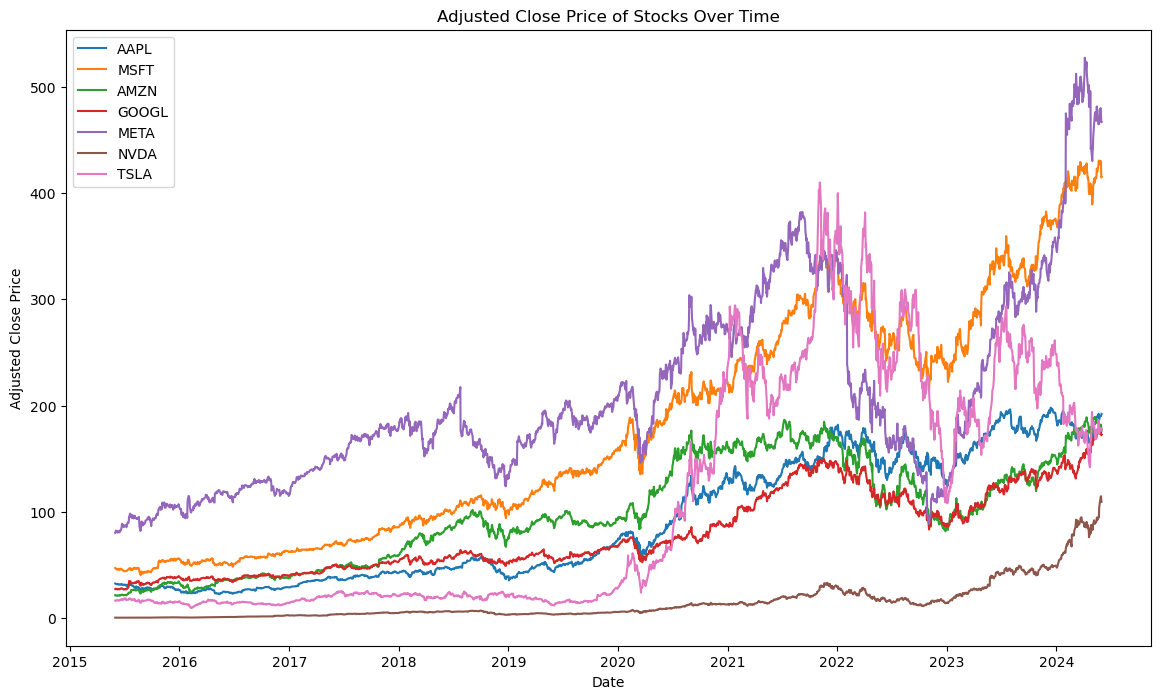

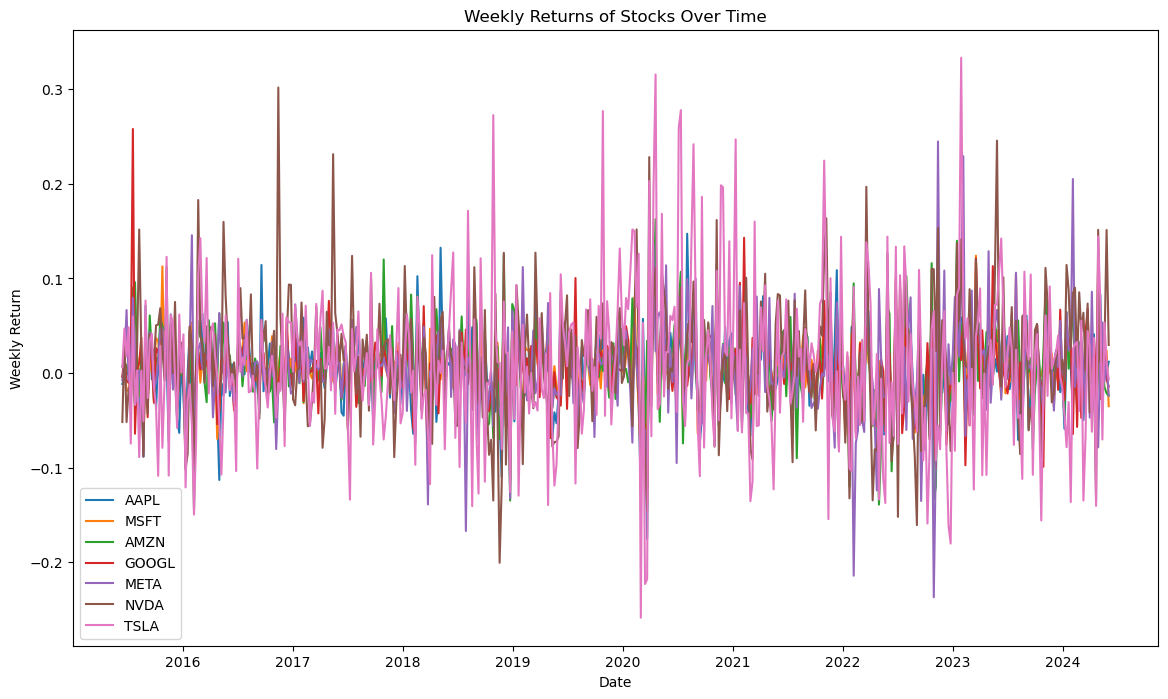

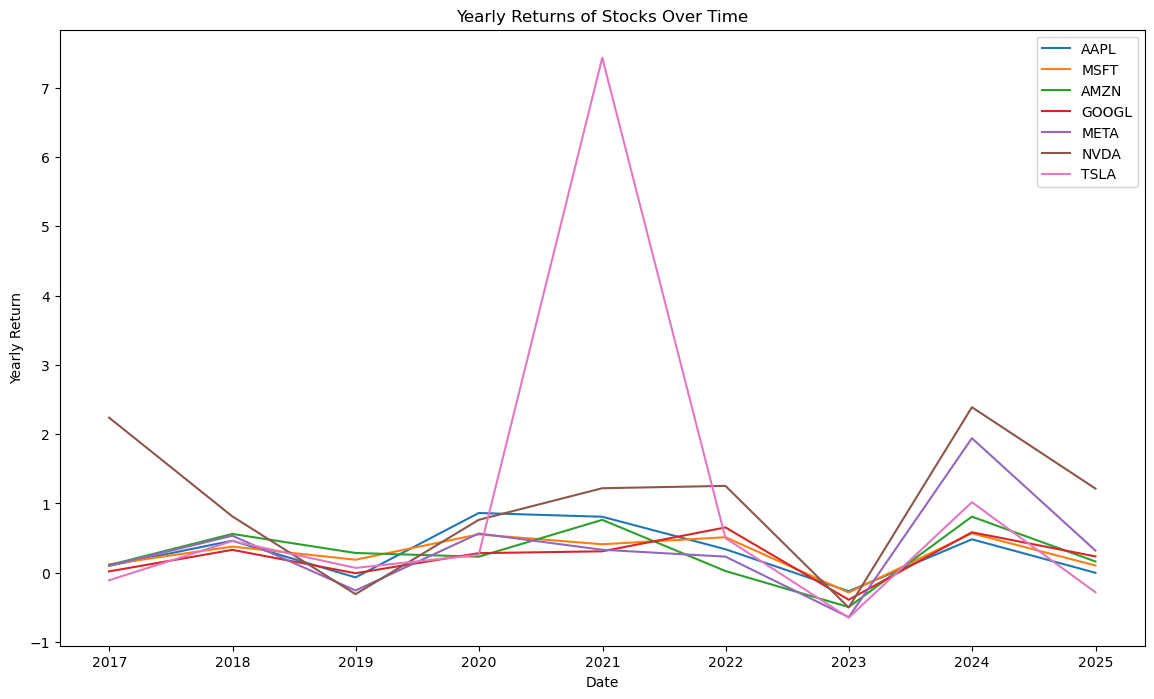

                 Average Weekly Return  Weekly Volatility  \
AAPL US Equity                0.004553           0.038292   
MSFT US Equity                0.005206           0.032055   
AMZN US Equity                0.005379           0.041609   
GOOGL US Equity               0.004666           0.038885   
META US Equity                0.004931           0.049408   
NVDA US Equity                0.013277           0.063164   
TSLA US Equity                0.008281           0.081040   

                 Average Yearly Return  Yearly Volatility  
AAPL US Equity                0.301437           0.390903  
MSFT US Equity                0.282684           0.279278  
AMZN US Equity                0.271537           0.403696  
GOOGL US Equity               0.223368           0.317977  
META US Equity                0.346871           0.710978  
NVDA US Equity                1.008365           0.980204  
TSLA US Equity                0.965415           2.473828  


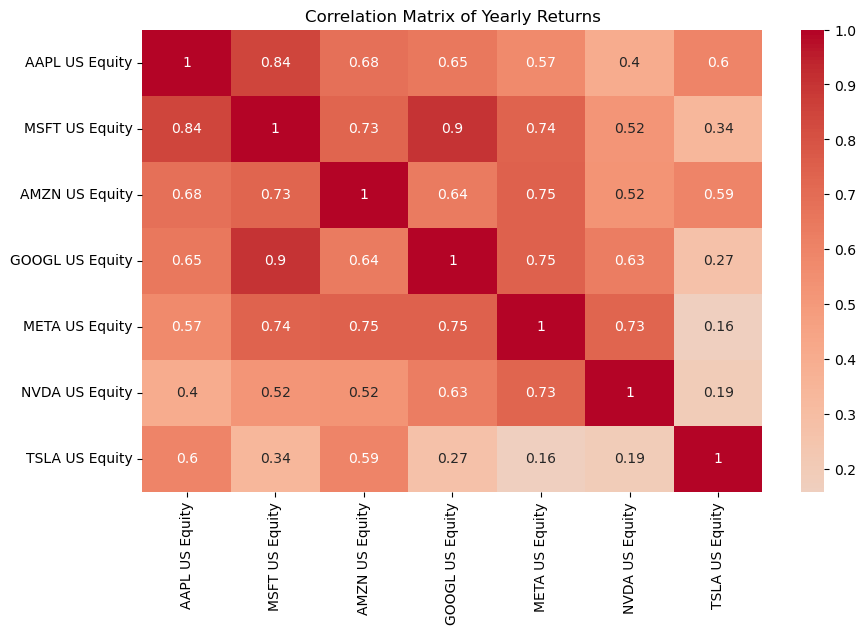

In [30]:
 
# List of stocks (Bloomberg tickers)
stocks = ['AAPL US Equity', 'MSFT US Equity', 'AMZN US Equity', 'GOOGL US Equity', 'META US Equity', 'NVDA US Equity', 'TSLA US Equity']
 
# Define the date range
start_date = '2015-06-01'
end_date = '2024-06-01'
 
# Fetch the data from Bloomberg
data = fetch_bloomberg_data(stocks, start_date, end_date)
 
# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)
 
# Show the first few rows of the data
print(data.head())
 
# Calculate weekly and yearly returns
weekly_data = data.resample('W').ffill().pct_change()
yearly_data = data.resample('Y').ffill().pct_change()
 
# Plot the closing price for each stock
plt.figure(figsize=(14, 8))
for stock in stocks:
    plt.plot(data[stock], label=stock.split(' ')[0])
plt.title('Adjusted Close Price of Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()
 
# Plot the weekly returns for each stock
plt.figure(figsize=(14, 8))
for stock in stocks:
    plt.plot(weekly_data[stock], label=stock.split(' ')[0])
plt.title('Weekly Returns of Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Return')
plt.legend()
plt.show()
 
# Plot the yearly returns for each stock
plt.figure(figsize=(14, 8))
for stock in stocks:
    plt.plot(yearly_data[stock], label=stock.split(' ')[0])
plt.title('Yearly Returns of Stocks Over Time')
plt.xlabel('Date')
plt.ylabel('Yearly Return')
plt.legend()
plt.show()
 
# Analysis: Calculate average and volatility
analysis = pd.DataFrame({
    'Average Weekly Return': weekly_data.mean(),
    'Weekly Volatility': weekly_data.std(),
    'Average Yearly Return': yearly_data.mean(),
    'Yearly Volatility': yearly_data.std()
})
 
# Display the analysis
print(analysis)
 
# Correlation matrix of yearly returns
plt.figure(figsize=(10, 6))
sns.heatmap(yearly_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Yearly Returns')
plt.show()